In [28]:
import numpy as np
import matplotlib.pyplot as plt

In [69]:
N_co =  3e-5 * 2e4
mu = 0.1 * 1e-18 # cgs
R = 5 * 3.086e+18 #from pc to cm
V = 30 *1e5 #km/s to cm/s
h = 6.6261 * 1e-27 #cm2 g s-1
k = 1.3807e-16 #cm2 g s-2 K-1
B = 5.76e10 #Hz
Tbb = 2.73 #k
c = 3e10 #cm/s

T = 25 + 273 #k
C = 2e4 * 7e-12 * T**(1/2)
A = 512 * B**3 * np.pi**4 * mu**2 / (3 * h * c**3) * 1/3

In [20]:
Js = np.arange(0, 11, 1)
n_js_table = np.array([0.1092, 0.0873, 0.0558, 0.0285, 0.0115, 0.0035, 0.00062, 0.000047, 0.0000034, 0.0000003, 0])
tau_table = np.array([8.46, 24.29, 31.61, 26.25, 15.53, 6.57, 1.56, 0.14, 0.011, 0.0011])
text_table = np.array([24.72, 24.77, 24.74, 24.42, 23.06, 19.39, 15.04, 16.77, 20.75, 21.21])


### level population n_js
### optical depth
### excitation temperature
### departure coefficient

## 1. Level population

####  $\tau_{j+1, j} = TAU(J+1)[n_{J} - n_{J+1}]$
#### $TAU=\frac{8\pi^{2}\mu^{2}RN_{CO}}{3hV}$  

#### $\beta_{j+1, j} = [1 - exp(-\tau_{j+1, j})]/\tau_{j+1, j}$

#### $0 = \beta_{j+1, j}\frac{(j+1)^{4}}{2j+1}(n_{j+1} - \frac{n_{j} - n_{j+1}}{exp(2hB(j+1))/kT_{BB} - 1}) - \beta_{j, j-1}\frac{(j)^{4}}{2j+1}(n_{j} - \frac{n_{j-1} - n_{j}}{exp(2hBj)/kT_{BB} - 1}) + \frac{C}{3A_{1,0}}[\sum\limits_{l = j+1}^{\infty}(2l+1)(n_{l} - n_{j}exp(\frac{hB}{kT}(j(j+1) - l(l+1)))) - \sum\limits_{l = 0}^{\infty}(j-1)(n_{j} - n_{l}exp(\frac{hB}{kT}(l(l+1) - j(j
+1))))]$ 

#### gauss-newton method를 사용해서 $n_{j}$의 값을 계산할 것이다.

In [62]:
import sympy as sp

In [148]:
ns = []
for i in range(len(Js)):
    n = sp.Symbol(f'n{i}')
    ns.append(n)

In [224]:
def find_beta(J): #j+1,j
    tau = TAU * (J+1) * (ns[J] - ns[J+1])
    b = (1 - sp.exp(-tau))/tau
    return b

In [225]:
def sum1(J):
    sum1 = 0
    for i in range(J+1, 11):
        sum1 += (2*J + 1) * (ns[i] - ns[J] * sp.exp(h*B/k/T*(J*(J+1) - i*(i+1))))

    return sum1

def sum2(J):
    sum2 = 0
    for i in range(0, J):
        sum2 += (2*i + 1) * (ns[J] - ns[i] * sp.exp(h*B/k/T*(i*(i+1) - J*(J+1))))
        
    return -sum2

In [230]:
def find_eq(J):
        
    if J < 1:
        b0 = find_beta(J)
        eq = b0 * (J+1)**4/(2*J+1) * (ns[J+1] - (ns[J] - ns[J+1])/(sp.exp(2*h*B*(J+1)/(k*Tbb)) - 1))\
            + C/3/A *sum1(J) 
    elif J > 9:
        b1 = find_beta(J-1)
        eq = - b1 * J**4/(2*J+1) * (ns[J] - (ns[J-1] - ns[J])/(sp.exp(2*h*B*J/(k*Tbb)) - 1))\
            + C/3/A * sum2(J)
    else:
        b0 = find_beta(J)
        b1 = find_beta(J-1)
        eq = b0 * (J+1)**4/(2*J+1) * (ns[J+1] - (ns[J] - ns[J+1])/(sp.exp(2*h*B*(J+1)/(k*Tbb)) - 1))\
            - b1 * J**4/(2*J+1) * (ns[J] - (ns[J-1] - ns[J])/(sp.exp(2*h*B*J/(k*Tbb)) - 1))\
            + C/3/A * (sum1(J) + sum2(J))
    return eq


In [231]:
f_list = []
for i in range(len(Js)):
    f_list.append(find_eq(i))
    
F = sp.Matrix(f_list)
# F = F.T

In [232]:
j_list = []
for i in range(len(Js)):
    j_list2 = []  
    eq = find_eq(i)
    for k in range(len(Js)):
        j_list2.append(sp.diff(eq, ns[k]))
    
    j_list.append(j_list2)
Jac = sp.Matrix(j_list)

In [216]:
# F2[0].subs(ns[0], 0)
# # F2[0]

In [234]:
F[6]

13.6095031504876*n0 + 40.8285094514628*n1 + 176.923540956339*n10 + 68.0475157524379*n2 + 95.2665220534131*n3 + 122.485528354388*n4 + 149.704534655363*n5 - 1197.63627724291*n6 + 176.923540956339*n7 + 176.923540956339*n8 + 176.923540956339*n9 - 1296*(-4.5035996273705e+15*n5 + 4.5035996273705e+15*n6)*(-exp(-2310.50831917189*n5 + 2310.50831917189*n6) + 1)/(13*(2310.50831917189*n5 - 2310.50831917189*n6)) + 2401*(-4.5035996273705e+15*n6 + 4.5035996273705e+15*n7)*(-exp(-2695.59303903387*n6 + 2695.59303903387*n7) + 1)/(13*(2695.59303903387*n6 - 2695.59303903387*n7))

In [249]:
#initial value
X_in = np.arange(0.11, 0, -0.01)
len(X_in)

11

In [250]:
#list to dictionary

X_init = {ns[i]: X_in[i] for i in range(len(Js))}

In [251]:
F2.subs(X_init)
# F2[0]

Matrix([
[               zoo],
[               nan],
[               nan],
[               nan],
[               zoo],
[ -96750272746094.8],
[-114252012062327.0],
[-131764656411421.0],
[-149284356636796.0],
[-166808884556293.0],
[ 556908945101132.0]])

In [252]:
Jac.subs(X_init)

Matrix([
[             nan,              nan, 13.6095031504876, 13.6095031504876, 13.6095031504876, 13.6095031504876, 13.6095031504876, 13.6095031504876, 13.6095031504876, 13.6095031504876, 13.6095031504876],
[             nan,              nan,              nan, 40.8285094514628, 40.8285094514628, 40.8285094514628, 40.8285094514628, 40.8285094514628, 40.8285094514628, 40.8285094514628, 40.8285094514628],
[13.6095031504876,              nan,              nan,              nan, 68.0475157524379, 68.0475157524379, 68.0475157524379, 68.0475157524379, 68.0475157524379, 68.0475157524379, 68.0475157524379],
[13.6095031504876, 40.8285094514628,              nan,              nan,              nan, 95.2665220534131, 95.2665220534131, 95.2665220534131, 95.2665220534131, 95.2665220534131, 95.2665220534131],
[13.6095031504876, 40.8285094514628, 68.0475157524379,              nan,              nan, 1358904346.85315, 122.485528354388, 122.485528354388, 122.485528354388, 122.485528354388, 122.485528

In [245]:
(Jac.T * Jac).inv() * Jac.T * F
# (Jac.T * Jac).inv

KeyboardInterrupt: 

In [125]:
#iteration
num_iter = 0
eps = 1e-5 #

while True:
    if num_iter == 0:
        X0 = X_init
    
    X_new = 
    
    

In [147]:
# ns[0] = 0
n0
# Jac2

NameError: name 'n0' is not defined

In [128]:
Jac2 = Jac.copy()

Jac2


Matrix([
[-1633.14037805851 + 385.084719861981*(n1 + zoo*(n0 - n1))*exp(-385.084719861981*n0 + 385.084719861981*n1)/(385.084719861981*n0 - 385.084719861981*n1) + zoo*(-exp(-385.084719861981*n0 + 385.084719861981*n1) + 1)/(385.084719861981*n0 - 385.084719861981*n1) - 385.084719861981*(n1 + zoo*(n0 - n1))*(-exp(-385.084719861981*n0 + 385.084719861981*n1) + 1)/(385.084719861981*n0 - 385.084719861981*n1)**2,                                                                                                                                                                                                                                                                                                                                                                                             40.8285094514628 - 385.084719861981*(n1 + zoo*(n0 - n1))*exp(-385.084719861981*n0 + 385.084719861981*n1)/(385.084719861981*n0 - 385.084719861981*n1) + zoo*(-exp(-385.084719861981*n0 + 385.084719861981*n1) + 1)/(3

In [132]:
n1
# Jac2

0

## 2. calculate optical depth
###  $\tau_{j+1, j} = TAU(J+1)[n_{J} - n_{J+1}]$
### $TAU=\frac{8\pi^{2}\mu^{2}RN_{CO}}{3hV}$  

In [24]:
TAU = 8 * np.pi**3 *mu**2 * R * N_co /(3*h*V)

In [25]:
tau_list = []
for i in range(len(Js)-1):
    t = TAU * (Js[i] + 1) * (n_js_table[i] - n_js_table[i+1])
    tau_list.append(t)
taus = np.array(tau_list)

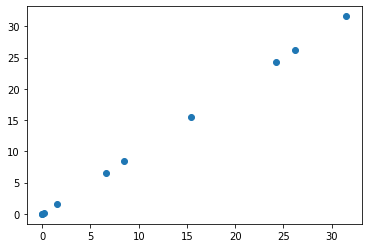

In [29]:
plt.scatter(taus, tau_table)

## 3. excitation temperature
### $T_{J, J-1} = \frac{2hBJ}{kln(\frac{n_{J-1}}{n_{J}})}$

In [33]:
temp_list = []
for i in range(1, len(Js)):
    temp = 2*h*B*Js[i] / (k * np.log(n_js_table[i-1]/n_js_table[i]))
    temp_list.append(temp)
temps = np.array(temp_list)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


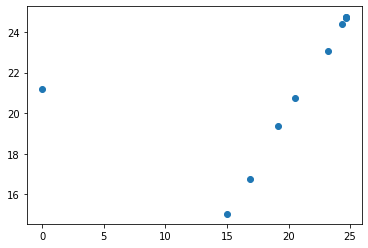

In [37]:
plt.scatter(temps, text_table)

## 3. departure 
